# Introduction

In this notebook I reproduce some of the plots in [this article](https://basedosdados.org/blog/bdletter-44-como-entender-as-exporta%C3%A7%C3%B5es-e-importa%C3%A7%C3%B5es-brasileiras) by the Brazilian data plataform [**Base dos Dados**](https://basedosdados.org/). 

This plataform has curated datasets from many public databases of Brazil. In the article, they explored the use of the data from **Comex Stat**.

* Comex Stat is the official Brazilian government system for foreign trade statistics, maintained by the Ministry of Development, Industry, Trade and Services (MDIC).

* The offical data repository for the foreign trade is at: https://www.gov.br/mdic/pt-br/assuntos/comercio-exterior/estatisticas/base-de-dados-bruta  

* This data can also be accessed via Base de Dados plataform [here](https://basedosdados.org/dataset/74827951-3f2c-4f9f-b3d0-56e3aa7aeb39?table=f4b08023-5530-4dc9-bced-3321e8928fd7&utm_source=hs_email&utm_medium=email&_hsenc=p2ANqtz--9a4I7710KnANEHDFtnaxgrM3vUAcZUQ6qM8sSL20Ibcq388Bz4GEy8IQhm59xTZBd7PPD).

Plots reproduced:
- **Produtos Primários X Produtos Manufaturados**: the original show the stats for 2024, here I reproduce the plot to 2025 (January-September). 
- **Quem Compra o Café do Brasil?**: I reproduced the plot with data from year 2024. 
- **Quem Compra o Petróleo do Brasil?**: This was not in the original article, but I have plot the countries that bought the Brazilian crude pretroleum in 2024. (Note for future self: to display the total exports in million of barrels per day, one needs to assume some density for the conversions.) 

In [1]:
import numpy as np
import pandas as pd
import random
import textwrap
import requests
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from io import BytesIO
import plotly.graph_objects as go

## Produtos Primários X Produtos Manufaturados

In [2]:
def filter_df(df):
    '''
    To separated the products in primary and manufactured categories, I followed the seletion criteria at
    https://github.com/basedosdados/analises/blob/main/redes_sociais/br_me_comex_stat_20251006.sql
    '''
    # extract first two digits (chapter number)
    df['chapter'] = df['SH4'].astype(str).str[:2].astype(int)

    # define HS chapter classification
    conditions = [
        df['chapter'].between(1, 24),
        df['chapter'].between(25, 27),
        df['chapter'].between(28, 40),
        df['chapter'].between(41, 49),
        df['chapter'].between(50, 63),
        df['chapter'].between(64, 83),
        df['chapter'].between(84, 90),
        df['chapter'].between(91, 97)
    ]

    choices = [
        'Produtos primários (Agropecuários)',
        'Produtos primários (Minerais e Combustíveis)',
        'Manufaturados (Químicos e Plásticos)',
        'Manufaturados (Madeira, Papel, Couro)',
        'Manufaturados (Têxteis e Vestuário)',
        'Manufaturados (Calçados, Metais, Produtos de Metais)',
        'Manufaturados (Máquinas e Eletrônicos)',
        'Manufaturados (Veículos, Aeronaves, Outros)'
    ]

    # apply classification
    df['categoria_produto'] = np.select(conditions, choices, default='Outros')

    # keep all quantities and add the new column
    return df

def get_totals(df):
    # sum by category
    df_sum = (
        df.groupby('categoria_produto', as_index=False)[['KG_LIQUIDO', 'VL_FOB']]
        .sum()
        .sort_values('VL_FOB', ascending=False)
    )

    return df_sum

# enhancements for the plot 
def break_before_paren(label, wrap_width=None):
    """
    Breaks text before '(' and optionally wraps the part before it.
    Keeps the text inside parentheses untouched.
    Makes the part before '(' bold.
    """
    idx = label.find('(')
    if idx == -1:
        # no parentheses: wrap and bold everything
        if wrap_width:
            left_wrapped = '\n'.join(textwrap.wrap(label, width=wrap_width))
        else:
            left_wrapped = label
        return rf"$\bf{{{left_wrapped}}}$"

    left = label[:idx].rstrip()
    paren = label[idx:].strip()

    # wrap only the left part if needed
    if wrap_width:
        left_wrapped = '\n'.join(textwrap.wrap(left, width=wrap_width))
    else:
        left_wrapped = left

    left_wrapped = left_wrapped.replace(" ", "\ ")   
    
    return rf"$\mathbf{{{left_wrapped}}}$" + "\n" + paren


In [3]:
# loading the exportation data 2025, SH4
df_exp0 = pd.read_csv('./locdata/EXP_2025_MUN.csv', sep=';')
df_exp0.head()

,CO_ANO,CO_MES,SH4,CO_PAIS,SG_UF_MUN,CO_MUN,KG_LIQUIDO,VL_FOB
0,2025,8,7612,845,SP,3409205,8486,143655
1,2025,1,7607,158,SP,3429401,6384,56674
2,2025,4,9603,177,SP,3450308,330,3942
3,2025,3,8441,63,SP,3456206,377,9990
4,2025,1,3824,351,RJ,3301702,1275,6744


In [4]:
# loading the importation data 2025, SH4
df_imp0 = pd.read_csv('./locdata/IMP_2025_MUN.csv', sep=';')
df_imp0.head()

,CO_ANO,CO_MES,SH4,CO_PAIS,SG_UF_MUN,CO_MUN,KG_LIQUIDO,VL_FOB
0,2025,1,9205,160,SP,3448708,965,37569
1,2025,8,3908,160,SP,3452502,350,3115
2,2025,1,7326,386,BA,2930709,0,6
3,2025,7,8544,607,RJ,3302254,3,1347
4,2025,5,8501,386,SP,3425904,97,13099


In [5]:
# split by categories and get total values of exp. 2025
df_exp = get_totals(filter_df(df_exp0))
df_exp.head()

,categoria_produto,KG_LIQUIDO,VL_FOB
6,Produtos primários (Agropecuários),176940699576,95177515537
7,Produtos primários (Minerais e Combustíveis),399180732573,67323928168
2,Manufaturados (Máquinas e Eletrônicos),4080822783,40121299581
0,"Manufaturados (Calçados, Metais, Produtos de M...",16052351384,22026305145
3,Manufaturados (Químicos e Plásticos),11201141970,14298078825


In [6]:
# split by categories and get total values of imp. 2025
df_imp = get_totals(filter_df(df_imp0))
df_imp.head()

,categoria_produto,KG_LIQUIDO,VL_FOB
2,Manufaturados (Máquinas e Eletrônicos),6412644390,91482870659
3,Manufaturados (Químicos e Plásticos),51385483307,60163954956
7,Produtos primários (Minerais e Combustíveis),57220429892,24120557042
0,"Manufaturados (Calçados, Metais, Produtos de M...",8921769613,17890335111
6,Produtos primários (Agropecuários),12351428125,8722975269


In [7]:
# merge the dataframes
df_compare = pd.merge(
    df_exp[['categoria_produto', 'VL_FOB']],
    df_imp[['categoria_produto', 'VL_FOB']],
    on='categoria_produto',
    suffixes=('_exp', '_imp')
)

# convert to billions 
df_compare['VL_FOB_exp_bi'] = df_compare['VL_FOB_exp'] / 1e9
df_compare['VL_FOB_imp_bi'] = df_compare['VL_FOB_imp'] / 1e9

# sort by export value 
df_compare = df_compare.sort_values('VL_FOB_exp_bi')
df_compare.head()

,categoria_produto,VL_FOB_exp,VL_FOB_imp,VL_FOB_exp_bi,VL_FOB_imp_bi
7,"Manufaturados (Veículos, Aeronaves, Outros)",1441241803,2854444636,1.441242,2.854445
6,Manufaturados (Têxteis e Vestuário),4443508055,5300613443,4.443508,5.300613
5,"Manufaturados (Madeira, Papel, Couro)",12960404109,1778086895,12.960404,1.778087
4,Manufaturados (Químicos e Plásticos),14298078825,60163954956,14.298079,60.163955
3,"Manufaturados (Calçados, Metais, Produtos de M...",22026305145,17890335111,22.026305,17.890335


In [8]:
# apply the wrapping logic to category names
df_compare['categoria_produto_wrap'] = df_compare['categoria_produto'].apply(
    lambda x: break_before_paren(x, wrap_width=25))  

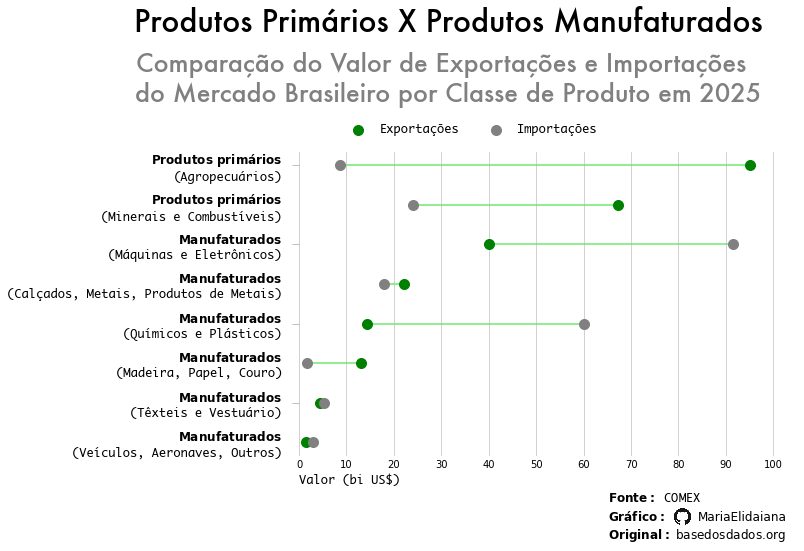

In [9]:
# plot imp. x exp. 2025

plt.figure(figsize=(10, 7))

for i, row in df_compare.iterrows():
    y_label = row['categoria_produto_wrap']
    plt.plot(
        [row['VL_FOB_exp_bi'], row['VL_FOB_imp_bi']],
        [y_label, y_label],
        color='lightgreen', linewidth=2, zorder=1
    )
    plt.scatter(row['VL_FOB_exp_bi'], y_label, color='green', s=100,
                label='Exportações' if i == 0 else "", zorder=2)
    plt.scatter(row['VL_FOB_imp_bi'], y_label, color='gray', s=100,
                label='Importações' if i == 0 else "", zorder=3)
            
plt.suptitle(
    "Produtos Primários X Produtos Manufaturados",
    fontsize=30,
    fontweight='bold',
    fontname='Futura',
    x=0.50,           
    ha='center'
)    

subtitle = """Comparação do Valor de Exportações e Importações  
do Mercado Brasileiro por Classe de Produto em 2025"""

title_obj = plt.title(subtitle, 
                      pad=50, 
                      fontsize=25, 
                      fontweight='bold', 
                      fontname='Futura',
                      x=0.30, 
                      ha='center')

plt.setp(title_obj, color='gray') 
plt.xlabel("Valor (bi US$)", fontname='Ayuthaya', fontsize=12, loc='left')
plt.legend(bbox_to_anchor=(0.62, 1.13), loc='upper right', ncol=2, frameon=False, 
           prop={'family': 'Ayuthaya', 'size': 12})
plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.xticks(np.arange(0, 110, 10))
plt.xlim(0, 105)
plt.box(on=False)
plt.tight_layout()

# using the wrapped labels on y-axis
plt.yticks(
    ticks=df_compare['categoria_produto_wrap'],
    labels=df_compare['categoria_produto_wrap']
)
plt.tick_params(axis='y', which='major', pad=10)
 
# left-align labels and add padding so they don't overlap the plot area
ax = plt.gca()
for tick in ax.get_yticklabels():
    tick.set_fontname("Ayuthaya")
    tick.set_fontsize(12)
    tick.set_ha('right')
    tick.set_va=('center')
    tick.set_labelpad=(10)

# increase padding between ticks and axis
ax.tick_params(axis='y', which='major', pad=35, length=7, width=0.5, colors='gray', labelcolor='black') 
ax.tick_params(axis='x', colors='white', labelcolor='black', pad=0.1)

# move slightly left
for tick in ax.get_yticklabels():
    tick.set_position((0.05, tick.get_position()[1]))  

# hide every other tick mark (not the labels)
for i, tick in enumerate(ax.yaxis.get_major_ticks()):
    if i % 2 == 0:  # every 2nd tick
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        
# adding credit lines
plt.text(
    0.62, -0.14, r"$\bf{Fonte:}$ COMEX",
    transform=ax.transAxes,
    fontsize=12,
    va='center',
    fontname='Ayuthaya'  
)
plt.text(
    0.62, -0.2, r"$\bf{Gráfico:}$ ",      
    transform=ax.transAxes,
    fontsize=12,
    va='center',
    fontname='Ayuthaya'  
)
url = "https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"
response = requests.get(url)
icon_img = mpimg.imread(BytesIO(response.content))

# creating an OffsetImage
icon = OffsetImage(icon_img, zoom=0.04)  
ab = AnnotationBbox(icon, (0.77, -0.2), 
                    xycoords='axes fraction',
                    frameon=False)
ax.add_artist(ab)

plt.text(
    0.8, -0.2, "MariaElidaiana",
    transform=ax.transAxes,
    fontsize=12,
    va='center'
)
plt.text(
    0.62, -0.26, r"$\bf{Original:}$ basedosdados.org",
    transform=ax.transAxes,
    fontsize=12,
    va='center'
)
# save
plt.savefig('comex_comparison_exp_imp_2025_br.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

## Quem Compra __ do Brasil?

In [10]:
def get_totals_kg(df):
    df_sum = (
        df.groupby(['CO_NCM', 'CO_PAIS'], as_index=False)['KG_LIQUIDO']
        .sum()
        .sort_values('KG_LIQUIDO', ascending=False)
    )
    return df_sum


def plottree(df_merged, idkey):
    
    import plotly.io as pio
    pio.renderers.default = "notebook_connected"

    if idkey=="09011110":
        df_merged['KT'] = df_merged['KG_LIQUIDO'] / 1e6  # thousand tonnes
        top_n=16
        sunit='KT'    # df string unit
        punit='mil t' # plot unit
        lunit='<sup>*</sup> Mil Toneladas' #legend unit
        scolor='#2E8B57' #green: figma Sea green
        utitle="<b>Quem Compra o Café do Brasil?"
        stitle="Maiores importadores do Café Verde <br> Brasileiro por peso líquido (<i>mil t</i>)<sup>*</sup> em 2024"
        sname="compradores_cafe_br_2024.png"
    elif idkey=="27090010":
        df_merged['MT'] = df_merged['KG_LIQUIDO'] / 1e9  # million tonnes
        top_n=15
        sunit='MT'
        punit='mt'
        lunit='<sup>*</sup> Milhões de Toneladas'
        scolor='#B31B1B' #red: figma Carnelian
        utitle="<b>Quem Compra o Petróleo do Brasil?"
        stitle="Maiores importadores do Petróleo Bruto Brasileiro <br> por peso líquido (<i>mt</i>)<sup>*</sup> em 2024"
        sname="compradores_petroleo_br_2024.png"
        
    df_top = df_merged.sort_values(sunit, ascending=False).head(top_n).copy()
    df_other = df_merged.sort_values(sunit, ascending=False).iloc[top_n:]
    others_sum = df_other[sunit].sum()

    # add "Demais Paises" at the end 
    df_top = pd.concat([
    df_top,
    pd.DataFrame({'NO_PAIS': ['Demais Países'], 'KG_LIQUIDO':[0], sunit:[others_sum]})], ignore_index=True)

    # force manual order 
    df_top['sort_order'] = range(len(df_top))
    df_top = df_top.sort_values('sort_order', ascending=True)

    # build color palette: first country selected color, remaining: gradient grayscale 
    n_others = len(df_top) - 1
    cmap = cm.get_cmap('Greys', n_others + 2) # perceptually uniform grayscale from light to dark
    # generate grayscale values 
    greys = [mcolors.to_rgba(cmap(i / (n_others + 1))) for i in range(1, n_others + 1)]

    # convert to rgba strings for Plotly
    greys = [f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})" for r, g, b, a in greys]
     
    # assign the greys randomly     
    random.seed(66)
    shuffled = greys[:-1]
    random.shuffle(shuffled)
    greys = shuffled + ["rgba(30,30,30,1)"]  # ensure "Demais Paises" are the darkest

    colors = [scolor] + greys

    # treemap
    fig = go.Figure(go.Treemap(
        labels=df_top['NO_PAIS'],
        parents=[""] * len(df_top),
        values=df_top[sunit],
        marker=dict(colors=colors),
        texttemplate="<b>%{label}</b><br><i>%{value:.1f} "+punit,
        textfont=dict(size=14),
        textposition="middle center",
        branchvalues="total",
        sort=False
    ))

    fig.update_layout(
        title=dict(
            text=utitle,
            x=0.5,
            font=dict(size=30, family="Futura", color='#666666')
        ),
        margin=dict(t=100, l=0, r=0, b=0),  # add more top space for subtitle
        annotations=[
            dict(
                text=stitle,
                x=0.5, y=1.05, 
                xref="paper", yref="paper",
                showarrow=False,
                font=dict(size=18, family="Avenir", color="gray") 
            )
        ]
    )


    # add credits
    fig.update_layout(
        width=950,   # width in pixels
        height=800,  # height in pixels
        margin=dict(t=70, l=0, r=0, b=120) # increase bottom margin for credits
    )
    fig.add_annotation(
        text=lunit,
        x=0.92, y=-0.05,
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=16, family="Avenir", color='gray'), 
        align="left"
    )
    fig.add_layout_image(
        dict(
            source="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png",
            xref="paper", yref="paper",
            x=0.883, y=-0.12,  # position relative to figure
            sizex=0.04, sizey=0.04,
            xanchor="left", yanchor="middle"
        )
    )
    fig.add_annotation(
        text="<b>Fonte:</b> COMEX",
        x=0.92, y=-0.10,
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=12, family="Futura"),
        align="left"
    )
    fig.add_annotation(
        text="<b>Gráfico:</b>       MariaElidaiana",
        x=1.0, y=-0.14, 
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=12, family="Futura"),
        align="left"
    )
    fig.add_annotation(
        text="<b>Original:</b> basedosdados.org",
        x=1.0, y=-0.18,
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=12, family="Futura"),
        align="left"
    )
    fig.show("png")
    fig.write_image(sname, scale=3)

### Café Verde

In [11]:
exp_2024_df = pd.read_csv('./locdata/EXP_2024.csv', sep=';')

exp_2024_df.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
0,2024,4,94036000,11,245,SP,4,817600,8,425,20423
1,2024,11,87088000,11,493,SP,1,817800,418615,60355,470512
2,2024,3,2071400,10,173,SP,1,817800,94080,94080,237562
3,2024,4,90303390,11,158,MG,1,817800,10,12,1704
4,2024,8,40129090,10,158,SC,4,817700,26,26,950


In [12]:
# select cafe verde using the id, and compute the total exports 
exp_cafe_sum_df = get_totals_kg(exp_2024_df[exp_2024_df["CO_NCM"] == int("09011110")])
exp_cafe_sum_df.head()

,CO_NCM,CO_PAIS,KG_LIQUIDO
34,9011110,249,453115167
1,9011110,23,440145259
10,9011110,87,261759143
50,9011110,386,232451329
51,9011110,399,137004646


In [13]:
# get countries names and codes
exp_cnames_df = pd.read_csv('./locdata/PAIS.csv', sep=';', encoding='latin1')
exp_cnames_df.head()

,CO_PAIS,CO_PAIS_ISON3,CO_PAIS_ISOA3,NO_PAIS,NO_PAIS_ING,NO_PAIS_ESP
0,0,898,ZZZ,Não Definido,Not defined,No definido
1,13,4,AFG,Afeganistão,Afghanistan,Afganistan
2,15,248,ALA,"Aland, Ilhas",Aland Islands,"Alans, Islas"
3,17,8,ALB,Albânia,Albania,Albania
4,20,724,ESP,"Alboran-Perejil, Ilhas","Alboran-Perejil, Islands","Alboran-Perejil, Islas"


In [14]:
# merge the dataframes on CO_PAIS
df_cafe_merged = pd.merge(
    exp_cafe_sum_df,
    exp_cnames_df[['CO_PAIS', 'NO_PAIS']], 
    on='CO_PAIS',
    how='left'  
)

df_cafe_merged.head()

,CO_NCM,CO_PAIS,KG_LIQUIDO,NO_PAIS
0,9011110,249,453115167,Estados Unidos
1,9011110,23,440145259,Alemanha
2,9011110,87,261759143,Bélgica
3,9011110,386,232451329,Itália
4,9011110,399,137004646,Japão


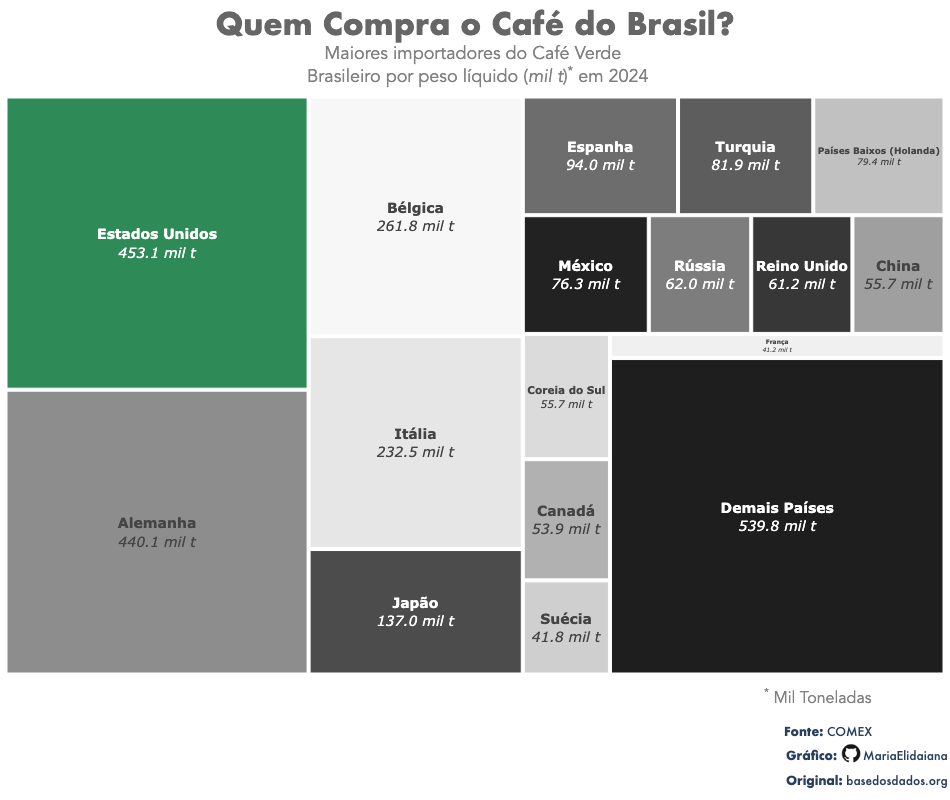

In [15]:
# do the plot
plottree(df_cafe_merged, "09011110")

### Petróleo bruto

In [16]:
# select petroleo using the id, and compute the total exports 
exp_petro_sum_df = get_totals_kg(exp_2024_df[exp_2024_df["CO_NCM"] == int("27090010")])
exp_petro_sum_df.head()

,CO_NCM,CO_PAIS,KG_LIQUIDO
2,27090010,160,39275008398
6,27090010,249,12196489370
5,27090010,245,9553250596
14,27090010,573,6339807014
16,27090010,607,4248714874


In [17]:
df_petro_merged = pd.merge(
    exp_petro_sum_df,
    exp_cnames_df[['CO_PAIS', 'NO_PAIS']], 
    on='CO_PAIS',
    how='left'  
)

df_petro_merged.head()

,CO_NCM,CO_PAIS,KG_LIQUIDO,NO_PAIS
0,27090010,160,39275008398,China
1,27090010,249,12196489370,Estados Unidos
2,27090010,245,9553250596,Espanha
3,27090010,573,6339807014,Países Baixos (Holanda)
4,27090010,607,4248714874,Portugal


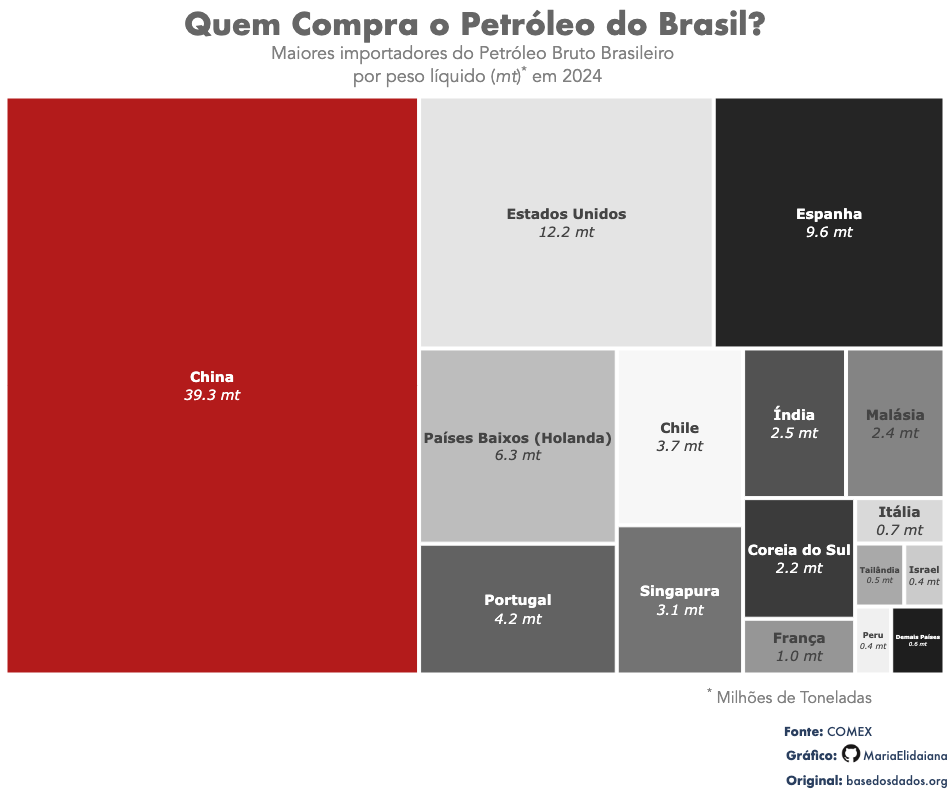

In [18]:
# do the plot
plottree(df_petro_merged, "27090010")